# exp8. News headlines

## 0. 들어가며

### 0.1 프로젝트 목표
***
뉴스 원문과 헤드라인이 있는 데이터셋을 이용해 원문으로부터 헤드라인을 추출하는 모델을 설계하고, 두 가지 기법을 비교한다.

* Extractive/Abstractive summarization 이해하기
* 단어장 크기를 줄이는 다양한 text normalization 적용해보기
* seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

### 0.2 루브릭
***

|**평가문항**|**상세기준**|
|------------|-------------|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과와 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

### 0.3 import

In [1]:
import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages') # 라이브러리 경로 오류

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Helpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_headlines/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
48848,"Appoint new CM, sack 6 ministers: TTV offers E...",Sidelined AIADMK leader TTV Dhinakaran has sai...
48389,"Had to flush pet as airline didn't let it fly,...",A 21-year-old woman has claimed she had to flu...
53270,Iran calls for Muslim unity to counter US' div...,The Secretary of Iran's Supreme National Secur...
92810,Only 1 Indian extradited from UK since treaty ...,Ever since India and the UK signed the Extradi...
80726,Players change underwear at Wimbledon since it...,"Boys' doubles top seeds, Hungary's Zsombor Pir..."
91694,"Saina exits Badminton Asia C'ships, Sindhu win...",Saina Nehwal was eliminated from the Badminton...
58292,Hat-trick of int'l wins when I won Miss Asia P...,Dia Mirza has shared a picture of her winning ...
90511,Muslim-dominated village sets Ã¢ÂÂ¹2.51L fine...,The panchayat in Uttar Pradesh's Madora villag...
44675,Bigg Boss contestant Arshi accuses priest of s...,Bigg Boss 11 contestant Arshi Khan has filed a...
80539,Kejriwal reconstitutes Delhi Minorities Commis...,Delhi Chief Minister Arvind Kejriwal on Friday...


## 2. 데이터 전처리하기(추상적 요약)

### 2.1 데이터 정리하기

In [14]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화와 불용어 제거

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [16]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [17]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [18]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

##  2.2 훈련데이터와 데스트데이터

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


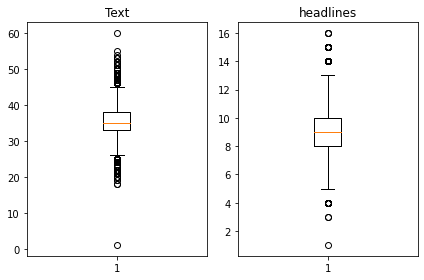

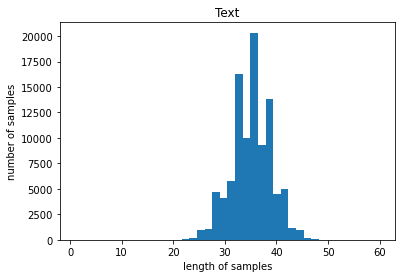

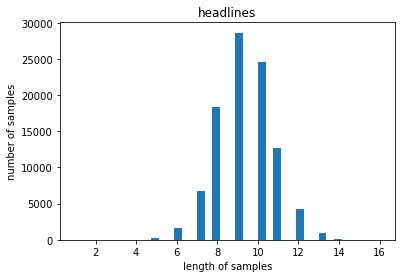

In [27]:
# 샘플의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines)))
print('요약의 최대 길이 : {}'.format(np.max(headlines)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
text_max_len = 40
headlines_max_len = 10
print('=3')

=3


In [32]:
# 각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [33]:
# 임의의 길이가 몇%의 샘플까지 포함하는지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [34]:
# 데이터가 정해진 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


시작 토큰과 종료 토큰 추가하기

In [35]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [36]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [37]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀸스를 만듦
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22065 55282 35592 ... 27900 25379 38617]


In [38]:
# 위에서 만든 정수 시퀸스를 이용해 다시 데이터의 샘플 순서를 정의해 줌 -> 잘 섞인 샘플
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [39]:
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [40]:
# 위에서 정의한 데트스 데이터의 개수를 이용해 전체 데이터를 앙분. :표시의 위치에 주의
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 2.3 단어 집합 제작 및 정수 인코딩

text 단어집합

In [41]:
'''
기계가 텍스트를 숫자로 처리할 수 있도록 훈련/테스트 데이터의 단어들을 모두 정수로 변환
이를 위해 각 단어에 고유한 정수를 맵핑필요 = 단어 집합(vocabulary)을 만든다
keras의 토크나이저를 이용해 encoder_input_train에 대해 단어 집합을 만들기
'''
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [42]:
'''
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 
이를 통해서 통계적인 정보를 얻을 수 있다.
'''
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61375
등장 빈도가 6번 이하인 희귀 단어의 수: 42040
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19335
단어 집합에서 희귀 단어의 비율: 68.4969450101833
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.17591723975095


In [43]:
'''
등장 빈도가 6회 이하인 단어들을 정수 인코딩에서 빼고, 훈련 데이터에서 제외
토크나이저를 정의할 때 num_words의 값을 정해주면 단어 집합의 크기를 제한 가능
'''
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [44]:
'''
texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 
텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행함
'''
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[98, 6153, 124, 894, 2193, 1506, 424, 4464, 2754, 1303, 1714, 1498, 1090, 1506, 82, 98, 1272, 1715, 2918, 98, 6435, 32, 124, 844, 2015, 124, 82, 1319, 98, 1506, 326], [55, 11756, 94, 206, 1220, 387, 2330, 13746, 3160, 263, 13747, 87, 334, 10962, 13746, 178, 3, 1484, 195, 158, 182, 9, 151, 158, 3038, 3160, 23, 15, 263, 97, 12189], [634, 73, 27, 274, 47, 433, 5258, 360, 192, 46, 34, 36, 139, 397, 270, 328, 39, 4182, 3739, 5589, 133, 3, 261, 52, 397, 4]]


headlines 단어집합

In [45]:
'''
headlines에도 동일한 작업 수행
decorder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
'''
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [46]:

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27277
등장 빈도가 5번 이하인 희귀 단어의 수: 18228
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9049
단어 집합에서 희귀 단어의 비율: 66.82553066686219
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.977635793716461


In [47]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 388, 986, 5, 5126, 1788, 183, 330, 45, 1789, 879], [1, 4470, 194, 8225, 2934, 5, 2858, 280], [1, 2083, 116, 5, 1922, 260, 145, 4, 23], [1, 663, 3, 200, 4, 680, 308, 3119, 6, 4471, 30], [1, 2253, 4864, 5743, 75, 4, 50]]
target
decoder  [[388, 986, 5, 5126, 1788, 183, 330, 45, 1789, 879, 2], [4470, 194, 8225, 2934, 5, 2858, 280, 2], [2083, 116, 5, 1922, 260, 145, 4, 23, 2], [663, 3, 200, 4, 680, 308, 3119, 6, 4471, 30, 2], [2253, 4864, 5743, 75, 4, 50, 2]]


In [48]:
'''
실제 길이가 1인 경우 제거
정수 인코딩 과정에서 빈도수가 낮은 단어를 삭제했고, 빈도수가 낮은 단어로만 구성된 샘플은 비었을 가능성이 높아짐
길이가 0인 샘플들이 발생했을 수 있으나, 토큰이 추가된 상태기 때문에 실제 길이는 1로 나옴
'''
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


패딩하기

In [49]:
# 아까 정해주었던 최디 길이로 패딩 진행. 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어서 진행함
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 2.4 모델 설계하기

In [50]:
# 함수형 api를 이용하여 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [51]:
'''
dropout = 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결하는 방법
recurrent dropout = dropout을 레이어가 아닌 time step마다 해주는 방식. time step의 입력을 랜덤으로 생략함
                    regularization을 해주는 효과와 과적합을 방지함
dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고 함.
'''

# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터의 차원
hidden_size = 256 # LSTM에서 얼만큼의 수용력(capacity)를 가질지 정함

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [52]:
'''
initial_state의 인자값으로 인코더의 hidden state와 cell state 값을 넣어줘야 함
'''
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [53]:
'''
디코더의 출력층에서는 summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 수행
그래서 Dense의 인자로 tar_vocab을 주고 활성화 함수로 softmax 사용
'''

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

## 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [54]:
from tensorflow.keras.layers import AdditiveAttention

'''
인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동
'''

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 4. 실제 결과와 요약문 비교하기(추상적 요약)

### 4.1 모델 훈련하기

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 428s 2s/step - loss: 6.3013 - val_loss: 5.8540
Epoch 2/50
232/232 [==============================] - 412s 2s/step - loss: 5.7655 - val_loss: 5.5165
Epoch 3/50
232/232 [==============================] - 383s 2s/step - loss: 5.4407 - val_loss: 5.2823
Epoch 4/50
232/232 [==============================] - 396s 2s/step - loss: 5.1670 - val_loss: 5.0572
Epoch 5/50
232/232 [==============================] - 340s 1s/step - loss: 4.9306 - val_loss: 4.8883
Epoch 6/50
232/232 [==============================] - 338s 1s/step - loss: 4.7286 - val_loss: 4.7610
Epoch 7/50
232/232 [==============================] - 346s 1s/step - loss: 4.5543 - val_loss: 4.6664
Epoch 8/50
232/232 [==============================] - 354s 2s/step - loss: 4.4017 - val_loss: 4.5783
Epoch 9/50
232/232 [==============================] - 369s 2s/step - loss: 4.2675 - val_loss: 4.4981
Epoch 10/50
232/232 [==============================] - 366s 2s/step - loss: 4.1429 - val_lo

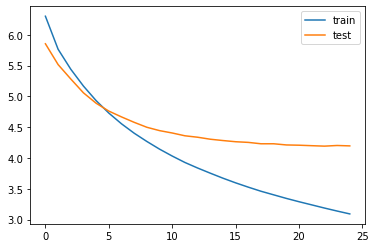

In [56]:
# 훈련 데이터의 손실과 검증 데이터의 손실 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4.2 인퍼런스 모델 구현

In [57]:
# 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야함 -> 필요한 3개의, 사전을 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [60]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 4.3 모델 테스트

In [71]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [80]:
for i in range(0, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : total pubs bars gurugram given clean chit metre liquor ban near state national highways include caf delhi heights hard rock caf punjabi nature vapour bar exchange meanwhile status pubs hotels remain scrutiny 
실제 요약 : bars near highways escape alcohol ban in gurugram 
예측 요약 :  gurugram civic body to get liquor shops


원문 : rti queries revealed brihanmumbai municipal corporation issued notices amitabh bachchan seven others alleged illegal constructions changed main maps make illegal constructions goregaon bungalows rti activist anil said reportedly written letters state cm devendra fadnavis seeking demolition illegal constructions 
실제 요약 : amitabh bachchan served notice for illegal construction rti 
예측 요약 :  delhi govt orders probe on strike against


원문 : pakistani lashkar taiba terrorist jat escaped police custody tuesday reportedly gunmen started firing outside srinagar hospital taken medical check policeman martyred another injured firing srinagar deputy inspector general ghulam

## 5. Summa을 이용해서 추출적 요약해보기

In [63]:
# 데이터 다운로드 하기
import requests
from summa.summarizer import summarize

In [64]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [65]:
# 일부만 출력하여 상태확인
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [69]:
'''
summa의 summarize는 내부적으로 문장 토큰화를 수행함. 
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
원문의 0.005%만을 출력하도록 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄임
'''
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [67]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 설정
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [70]:
# 단어의 수로 요약문의 크기 조절도 가능함
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [77]:
org_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [78]:
for i in range(0, 50):
    print("원문 :", org_data['text'][i])
    print("실제 요약 :", org_data['headlines'][i])
    print("예측 요약 :", summarize(org_data['text'][i], ratio=0.4))
    
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

### 5.1 추상적 요약과 추출적 요약 비교 

원문 : congress spokesperson randeep surjewala today accused pm narendra modi led government treating issue instant triple talaq political football matter justice muslim women surjewala said government congress request provision attach property men provide compensation affected women following divorce  
실제 요약 : triple talaq issue is political football for govt congress  
예측 요약 :  `pm modi` calls `triple talaq` bill `against`  

**평가 : 문법과 내용이 모두 어색하지 않음**

원문 : number deaths swine flu mumbai risen cases reported far year according reports notably swine flu deaths reported mumbai meanwhile cases swine flu deaths reported across maharashtra year  
실제 요약 : swine flu causes deaths in mumbai this year  
예측 요약 :  `killed` in due to `floods` in   

**평가 : flu / flood가 잘못 구분된듯 함**

원문 : first draft national register citizens assam recognised crore people indian citizens verification process rest crore applicants still registrar general india said sunday assam witnessed influx migrants bangladesh became state nrc  
실제 요약 : assam recognises cr legal citizens in first nrc draft  
예측 요약 :  govt to spend crore to families of   

**평가 : 의미를 알 수 없는 문장**

원문 : rbi sell least additional billion support rupee sbi estimated based intervention patterns since india forex reserves fallen peak billion april billion september notably rupee closed fresh low dollar tuesday  
실제 요약 : rbi can sell another billion to defend rupee sbi  
예측 요약 :  `rbi` shares hit bn after merger with  

**평가 : rbi 외에는 전혀 다른 의미의 문장**

원문 : pakistan planning seize financial assets charities run mastermind lashkar taiba founder hafiz saeed according reuters report government plans take jamaat ud dawa charity wing foundation reports added crackdown comes amid us demands pakistan act terrorists  
실제 요약 : pak plans to seize hafiz saeed financial assets report  
예측 요약 :  hafiz saeed hafiz saeed to hafiz saeed   

**평가 : 멍청함**

***

원문 : Former Windies fast bowler Curtly Ambrose dismissed seven Australian batsmen within a span of 32 balls giving away just one run, in a Test match on January 30, 1993. Ambrose's spell helped his team bowl out Australia for 119 in the first innings, after being 85 for 2 at one point. `Ambrose ended with first-innings figures of 18-9-25-7.`  
실제 요약 : Pacer once took 7 wickets for just 1 run in 32 balls in a Test  
예측 요약 : `Ambrose ended with first-innings figures of 18-9-25-7.`  


원문 : A London zoo is offering people to name a cockroach after their exes on Valentine's Day for ÃÂ£1.50 (nearly Ã¢ÂÂ¹140). "For those that don't quite require revenge, there's another way to make you feel better about getting back at your ex," the zoo said in a statement. `The names will appear on zoo's 'roach board' on February 14.`  
실제 요약 : UK zoo offers people to name cockroach after their ex on Valentine's  
예측 요약 : `The names will appear on zoo's 'roach board' on February 14.`  


원문 : Stand-in captain Rohit Sharma has become the 14th Indian cricketer to play 200 ODIs, achieving the feat after taking the field against New Zealand in fourth ODI at Hamilton on Thursday. The 31-year-old had made his ODI debut on June 23, 2007, against Ireland in Belfast. `Rohit scored 7,799 runs in his first 199 ODIs at an average of 48.14.`  
실제 요약 : Rohit Sharma becomes 14th Indian cricketer to play 200 ODIs  
예측 요약 : `Rohit scored 7,799 runs in his first 199 ODIs at an average of 48.14.`  


원문 : Batsman Shubman Gill has become the 227th cricketer to represent India in ODI cricket, achieving the feat against New Zealand in the fourth ODI at Hamilton on Thursday. The 19-year-old received his maiden ODI cap from former captain MS Dhoni. `Notably, Shubman was named Player of the Under-19 World Cup in New Zealand last year.`  
실제 요약 : 19-year-old Shubman Gill becomes India's 227th ODI cricketer  
예측 요약 : `Notably, Shubman was named Player of the Under-19 World Cup in New Zealand last year.`  


원문 : `Investigators searching for a lost plane carrying Argentine forward Emiliano Sala found two seat cushions on French coast that "likely" belonged to the aircraft.` The investigators said they'll now launch an underwater seabed search for aircraft wreckage. The Cardiff City footballer was travelling from France's Nantes to Wales' Cardiff when his plane disappeared over English Channel on January 21.  
실제 요약 : 2 seat cushions from 'missing plane carrying footballer' found  
예측 요약 : `Investigators searching for a lost plane carrying Argentine forward Emiliano Sala found two seat cushions on French coast that "likely" belonged to the aircraft.`  

## 느낀점

1. 추출적 요약의 경우 특정 문장을 통째로 가져오는 경우가 매우 많았다. 문장을 그대로 가져오니 내용이 어느정도 일치하고 문법상 어색함은 없으나, 단 하나의 문장이 해당 text 전체를 나타낼 수는 없는 한계점이 있다.
2. 추상적 요약의 경우 예측 결과가 본 text의 내용을 충분히 요약하거나 맥락을 이어가지 못했다. 소수의 훌륭한 예측 결과들은 본 text의 핵심을 비슷하게 표현하는 경우도 있어, 모델의 성능 여부가 중요한 것으로 보인다.
3. 추상적 요약을 진행하면서 최종 결과물 앞에 전부 `스페이스바` 한 칸이 입력된 채로 출력되었다.  
exp8 프로젝트는 exp8 노드를 진행하면서 정리한 코드를 그대로 사용했는데, 노드를 정리하는 과정 어딘가에서 코드를 잘못 입력한 것 같다. 어느 부분인지는 찾아내지 못했다..
4. 이전에 진행했던 nlp 관련 exp에서 패딩을 앞에 붙이는지 뒤에 붙이는 지에 따라 모델 성능에 유의미한 변화가 있다고 했었는데, 이번 exp에서도 적용되는 내용인지 궁금점이 들었지만 모델 훈련하는데 많은 시간이 소요되어 시도해보지 못했다.